
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
Digital Image Processing <br>
<font color=2565AE size=5>
Department Of Mathematical Sciences <br>
Spring 2025<br>
<font color=3C99D size=5>
Assignment 3 <br>
</div>


---



### Full Name : kousha moeini
### Student Number : 401100228
___

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def save_image(image, filename='output_image.jpg'):
    plt.imsave(filename, image, cmap='gray')

## Step 1: Divide image into 8x8 blocks and apply DCT
## (use realimage.jpg)

In [53]:
def apply_dct(image_array):
    def dct_1d(vector):
        N = len(vector)
        result = np.zeros(N, dtype=np.float32)
        factor = np.pi / N
        for k in range(N):
            sum_val = 0.0
            for n in range(N):
                sum_val += vector[n] * np.cos(factor * (n + 0.5) * k)
            result[k] = sum_val
        result[0] *= np.sqrt(1 / N)
        result[1:] *= np.sqrt(2 / N)
        return result

    def dct_2d(block):
        N = block.shape[0]
        temp = np.zeros_like(block, dtype=np.float32)
        result = np.zeros_like(block, dtype=np.float32)
        for i in range(N):
            temp[i, :] = dct_1d(block[i, :])
        for j in range(N):
            result[:, j] = dct_1d(temp[:, j])
        return result

    height, width = image_array.shape
    size = 8
    transformed = np.empty_like(image_array, dtype=np.float32)

    for row in range(0, height, size):
        for col in range(0, width, size):
            patch = image_array[row:row+size, col:col+size]
            dct_patch = dct_2d(patch)
            transformed[row:row+size, col:col+size] = dct_patch

    return transformed

## Step 2: Quantization


In [21]:
# Quantization matrix

Z = np.array([[16,11,10,16,24,40,51,61],
              [12,12,14,19,26,58,60,55],
              [14,13,16,24,40,57,69,56],
              [14,17,22,29,51,87,80,62],
              [18,22,37,56,68,109,103,77],
              [24,35,55,64,81,104,113,92],
              [49,64,78,87,103,121,120,101],
              [72,92,95,98,112,100,130,99]])

In [22]:
def quantize(dct_blocks):
    h, w = dct_blocks.shape
    block_size = 8
    quantized_blocks = np.zeros_like(dct_blocks, dtype=np.int32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_blocks[i:i+block_size, j:j+block_size]
            quant_block = np.round(block / Z).astype(np.int32)
            quantized_blocks[i:i+block_size, j:j+block_size] = quant_block

    return quantized_blocks

### Matrix to vector
Now you need to convert the matrix to an array like this:

`[-17, 0, -19, ..., 'EOB']`

In [23]:
def zigzag_scan(block):
    index_order = sorted(((x, y) for x in range(8) for y in range(8)),
                         key=lambda s: (s[0]+s[1], -s[1] if (s[0]+s[1])%2 else s[1]))
    return np.array([block[i,j] for i,j in index_order])
def mat_2_vec(jpeg_matrix):
    h, w = jpeg_matrix.shape
    block_size = 8
    jpeg_vector1 = []

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = jpeg_matrix[i:i+block_size, j:j+block_size]
            zz = zigzag_scan(block)
            jpeg_vector1.extend(zz)
    jpeg_vector=np.array(jpeg_vector1, dtype=np.int32)
    return jpeg_vector

In [47]:
def apply_idct(encoded_blocks):
    def idct_1d(vector):
        N = len(vector)
        result = np.zeros(N, dtype=np.float32)
        factor = np.pi / N
        for n in range(N):
            sum_val = vector[0] * np.sqrt(1 / N)
            for k in range(1, N):
                sum_val += vector[k] * np.sqrt(2 / N) * np.cos(factor * k * (n + 0.5))
            result[n] = sum_val
        return result

    def idct_2d(block):
        N = block.shape[0]
        temp = np.zeros_like(block, dtype=np.float32)
        result = np.zeros_like(block, dtype=np.float32)
        for i in range(N):
            temp[i, :] = idct_1d(block[i, :])
        for j in range(N):
            result[:, j] = idct_1d(temp[:, j])
        return result

    height, width = encoded_blocks.shape
    size = 8
    output_image = np.empty_like(encoded_blocks, dtype=np.float32)

    for row in range(0, height, size):
        if row + size > height:
            continue
        for col in range(0, width, size):
            if col + size > width:
                continue
            segment = encoded_blocks[row:row+size, col:col+size]
            restored = segment * Z
            idct_result = idct_2d(restored)
            output_image[row:row+size, col:col+size] = idct_result

    clipped = np.clip(output_image, 0, 255)
    return clipped.astype(np.uint8)


##B) Reverse steps

In [25]:
def vec_2_mat(jpeg_vector, image_shape=(512,512), block_size=8):
    h, w = image_shape
    quantized_blocks = np.zeros((h, w), dtype=np.int32)
    block_count_h = h // block_size
    block_count_w = w // block_size
    index_order = sorted(((x, y) for x in range(block_size) for y in range(block_size)),
                         key=lambda s: (s[0]+s[1], -s[1] if (s[0]+s[1])%2 else s[1]))

    idx = 0
    for i in range(block_count_h):
        for j in range(block_count_w):
            block = np.zeros((block_size, block_size), dtype=np.int32)
            for pos in index_order:
                block[pos] = jpeg_vector[idx]
                idx += 1
            quantized_blocks[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = block
    return quantized_blocks

def decompress_from_vector(jpeg_vector, image_shape=(512,512)):
    quantized_blocks = vec_2_mat(jpeg_vector, image_shape)
    decompressed_image = apply_idct(quantized_blocks)
    return decompressed_image

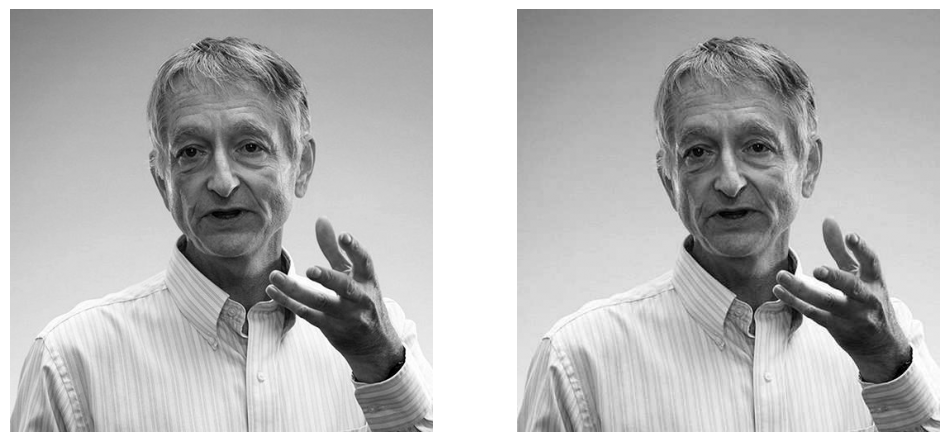

In [ ]:
#import for image input
import imageio.v3 as iio
from skimage import color, transform
def run_jpeg_on_image(image_path):
    img = iio.imread(image_path)
    if img.ndim == 3:
        img = color.rgb2gray(img)
        img = (img * 255).astype(np.uint8)

    img = transform.resize(img, (512,512), anti_aliasing=True)
    img = (img * 255).astype(np.uint8)

    dct_blocks = apply_dct(img)
    quantized_blocks = quantize(dct_blocks)
    jpeg_vector = mat_2_vec(quantized_blocks)
    decompressed_image = decompress_from_vector(jpeg_vector, image_shape=(512,512))
    save_image(decompressed_image, 'reconstructed.jpg')
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(decompressed_image, cmap='gray')
    plt.axis('off')
    plt.show()

    return img, decompressed_image, jpeg_vector

original, reconstructed, compressed_vector = run_jpeg_on_image('../assets/images/realImage.jpg')

##C) Calculate MSE,PSNR, SSIM

In [ ]:
from skimage.metrics import structural_similarity as ssim

def calculate_mse(original, reconstructed):
    return np.mean((original.astype(np.float64) - reconstructed.astype(np.float64)) ** 2)

def calculate_psnr(mse, max_pixel=255.0):
    if mse == 0:
        return float('inf')
    return 10 * np.log10((max_pixel ** 2) / mse)

def calculate_ssim(original, reconstructed):
    return ssim(original, reconstructed, data_range=255)

def calculate_compression_ratio(original_shape, jpeg_vector):
    original_bits = original_shape[0] * original_shape[1] * 8
    compressed_bits = jpeg_vector.size * 32
    return original_bits / compressed_bits

def evaluate(original, reconstructed, jpeg_vector):
    mse_val = calculate_mse(original, reconstructed)
    psnr_val = calculate_psnr(mse_val)
    ssim_val = calculate_ssim(original, reconstructed)
    compression_ratio = calculate_compression_ratio(original.shape, jpeg_vector)

    return mse_val, psnr_val, ssim_val, compression_ratio


In [ ]:
mse_val, psnr_val, ssim_val, compression_ratio = evaluate(original, reconstructed, compressed_vector)

print(f"MSE: {mse_val:.4f}")
print(f"PSNR: {psnr_val:.4f} dB")
print(f"SSIM: {ssim_val:.4f}")
print(f"Compression Ratio: {compression_ratio:.4f}")


MSE: 16.9887
PSNR: 35.8292 dB
SSIM: 0.9546
Compression Ratio: 0.2500
